In [1]:
# ===========================================================
#  library
# ===========================================================
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

In [2]:
# ===========================================================
#  CFG
# ===========================================================
class CFG:
    seed = 42
    n_splits = 5
    data_dir = "G:/マイドライブ/signate_MUFJ2023/data/"
    num_boost_round = 10000
    stopping_rounds = 1500
    save_dir = "G:/マイドライブ/signate_MUFJ2023/exp/"

In [3]:
# ===========================================================
#  Utils
# ===========================================================
def get_score(y_true, y_pred):
    """
    評価関数の入力となる検証用データ、及び学習に使用する学習用データの目的変数について、
    1: 不正利用あり, 0: 不正利用なしとします。
    """
    return f1_score(y_true, y_pred)

## train & test

| カラム | ヘッダ名称      | データ型   | 説明                                |
|-------|--------------|----------|------------------------------------|
| 0     | index        | int      | インデックス                          |
| 1     | user_id      | int      | ユーザーのID番号                      |
| 2     | card_id      | int      | 各ユーザーが保有しているカードの識別用ID |
| 3     | amount       | varchar  | カード取引額                         |
| 4     | errors?      | varchar  | 取引が成立したかどうか                 |
| 5     | is_fraud?    | int      | 不正利用の有無（不正利用あり=1, 不正利用なし=0） |
| 6     | merchant_id  | int      | 利用店舗ID                          |
| 7     | merchant_city| varchar  | 利用店舗所在市町村                     |
| 8     | merchant_state | char    | 利用店舗所在州                       |
| 9     | zip          | float    | 利用店舗郵便番号                      |
| 10    | mcc          | int      | 加盟店業種コード                      |
| 11    | use_chip     | varchar  | カード取引方法                        |


In [4]:
train = pd.read_csv("data/train.csv")
print(train.shape)
print(train.info())
train.head()

(471283, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 471283 entries, 0 to 471282
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           471283 non-null  int64  
 1   user_id         471283 non-null  int64  
 2   card_id         471283 non-null  int64  
 3   amount          471283 non-null  object 
 4   errors?         471283 non-null  object 
 5   is_fraud?       471283 non-null  int64  
 6   merchant_id     471283 non-null  int64  
 7   merchant_city   471283 non-null  object 
 8   merchant_state  400595 non-null  object 
 9   zip             392063 non-null  float64
 10  mcc             471283 non-null  int64  
 11  use_chip        471283 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 43.1+ MB
None


,index,user_id,card_id,amount,errors?,is_fraud?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,0,1721,0,$2.623,OK,0,209237,Joliet,IL,60436.0,5541,Swipe Transaction
1,1,1629,3,$6.4,OK,0,2568,Edgerton,WI,53534.0,5814,Swipe Transaction
2,2,655,3,$123.5,OK,0,345310,Ridgefield,WA,98642.0,7538,Swipe Transaction
3,3,492,0,$51.287,OK,0,4295,Milton,FL,32583.0,5912,Chip Transaction
4,4,1969,4,$17.561,OK,0,350447,Irvington,NJ,7111.0,4214,Swipe Transaction


In [5]:
# amount
train["amount"] = train["amount"].apply(lambda x:x[1:]).astype(float)

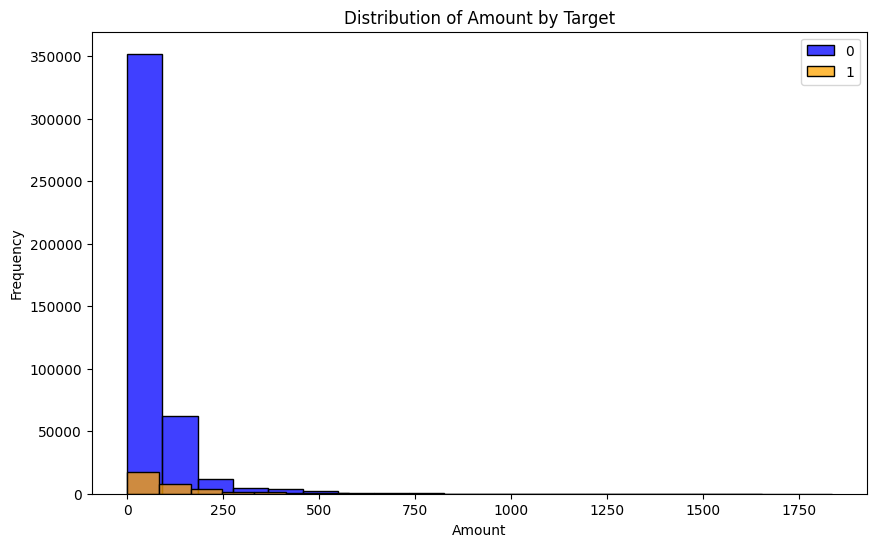

In [6]:
plt.figure(figsize=(10, 6))
sns.histplot(train[train['is_fraud?'] == 0]['amount'], bins=20, color='blue', label='0')
sns.histplot(train[train['is_fraud?'] == 1]['amount'], bins=20, color='orange', label='1')
plt.title('Distribution of Amount by Target')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

In [7]:
train[train["is_fraud?"] == 1]["amount"].describe(), train[train["is_fraud?"] == 0]["amount"].describe(), 

(count    32631.000000
 mean       116.459783
 std        130.895622
 min          0.010000
 25%         28.000000
 50%         76.700000
 75%        154.000000
 max       1651.552000
 Name: amount, dtype: float64,
 count    438652.000000
 mean         63.195395
 std          85.488668
 min           0.001000
 25%          14.780000
 50%          40.000000
 75%          80.000000
 max        1833.825000
 Name: amount, dtype: float64)

In [8]:
train.describe()

,index,user_id,card_id,amount,is_fraud?,merchant_id,zip,mcc
count,471283.000000,471283.000000,471283.000000,471283.000000,471283.000000,471283.000000,392063.000000,471283.000000
mean,235641.000000,1054.456562,1.735567,66.883350,0.069239,208349.620071,52575.379857,5582.452335
std,136047.827795,547.842878,1.655869,90.395838,0.253860,117299.644100,27653.240548,1038.271616
min,0.000000,39.000000,0.000000,0.001000,0.000000,58.000000,1012.000000,1711.000000
25%,117820.500000,655.000000,0.000000,15.208000,0.000000,109014.000000,30752.000000,5300.000000
50%,235641.000000,1033.000000,1.000000,41.920000,0.000000,214279.000000,48357.000000,5499.000000
75%,353461.500000,1571.000000,3.000000,83.193500,0.000000,311083.000000,76384.000000,5814.000000
max,471282.000000,1986.000000,8.000000,1833.825000,1.000000,407238.000000,99829.000000,9402.000000


In [10]:
len(train["merchant_id"].unique())

25076

In [32]:
test = pd.read_csv("data/test.csv")
print(test.shape)
print(test.info())
test.head()

(457958, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 457958 entries, 0 to 457957
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   index           457958 non-null  int64  
 1   user_id         457958 non-null  int64  
 2   card_id         457958 non-null  int64  
 3   amount          457958 non-null  object 
 4   errors?         457958 non-null  object 
 5   merchant_id     457958 non-null  int64  
 6   merchant_city   457958 non-null  object 
 7   merchant_state  388444 non-null  object 
 8   zip             380060 non-null  float64
 9   mcc             457958 non-null  int64  
 10  use_chip        457958 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 38.4+ MB
None


,index,user_id,card_id,amount,errors?,merchant_id,merchant_city,merchant_state,zip,mcc,use_chip
0,471283,541,3,$113.278,OK,324189,Orlando,FL,32821.0,4814,Swipe Transaction
1,471284,655,1,$293.944,OK,81219,Ridgefield,WA,98642.0,7538,Chip Transaction
2,471285,492,0,$47.4,OK,274755,Arlington Heights,IL,60004.0,5719,Swipe Transaction
3,471286,236,1,$167.0,OK,255962,Berkeley,CA,94702.0,5300,Swipe Transaction
4,471287,882,2,$126.619,ERROR,271748,Rochester,MN,55901.0,4829,Swipe Transaction


In [33]:
# amount
test["amount"] = test["amount"].apply(lambda x:x[1:]).astype(float)

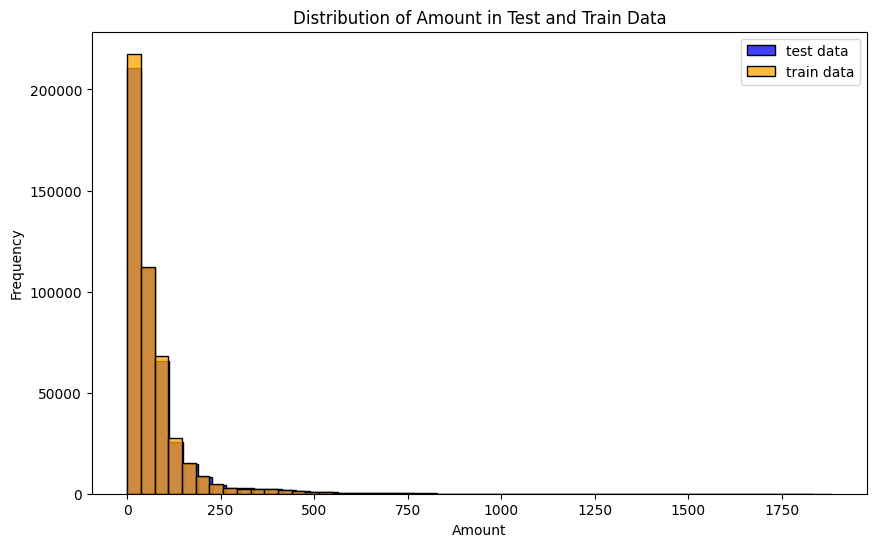

In [34]:
plt.figure(figsize=(10, 6))
sns.histplot(test["amount"], bins=50, color='blue', label='test data')
sns.histplot(train["amount"], bins=50, color='orange', label='train data')
plt.title('Distribution of Amount in Test and Train Data')
plt.xlabel('Amount')
plt.ylabel('Frequency')
plt.legend()
plt.show()

## Card

| カラム                | ヘッダ名称           | データ型   | 説明                           |
|----------------------|-------------------|----------|-------------------------------|
| 0                    | user_id           | int      | ユーザーのID番号                |
| 1                    | card_id           | int      | 各ユーザーが保有しているカードの識別用ID |
| 2                    | card_brand        | varchar  | カードのブランド                |
| 3                    | card_type         | varchar  | カードタイプ                    |
| 4                    | expires           | varchar  | 有効期限                        |
| 5                    | has_chip          | varchar  | Chipがあるかどうか               |
| 6                    | cards_issued      | int      | アカウントに紐づくカードの発行枚数 |
| 7                    | credit_limit      | varchar  | 利用可能額上限                  |
| 8                    | acct_open_date    | varchar  | アカウント作成日                |
| 9                    | year_pin_last_changed | int  | pinコードを最後に変更した日     |


In [40]:
card = pd.read_csv("data/card.csv")
print(card.shape)
print(card.info())
card.head()

(416, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 416 entries, 0 to 415
Data columns (total 10 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                416 non-null    int64 
 1   card_id                416 non-null    int64 
 2   card_brand             416 non-null    object
 3   card_type              416 non-null    object
 4   expires                416 non-null    object
 5   has_chip               416 non-null    object
 6   cards_issued           416 non-null    int64 
 7   credit_limit           416 non-null    object
 8   acct_open_date         416 non-null    object
 9   year_pin_last_changed  416 non-null    int64 
dtypes: int64(4), object(6)
memory usage: 32.6+ KB
None


,user_id,card_id,card_brand,card_type,expires,has_chip,cards_issued,credit_limit,acct_open_date,year_pin_last_changed
0,39,0,Visa,Debit,09/2021,YES,1,$17117,05/2007,2010
1,39,1,Amex,Credit,11/2024,YES,2,$5400,10/2015,2015
2,41,0,Discover,Credit,03/2022,YES,2,$14800,12/2010,2011
3,41,1,Mastercard,Debit,09/2024,YES,2,$4183,09/2010,2010
4,41,2,Mastercard,Debit,03/2024,YES,1,$6732,02/2010,2010


## user

| カラム                      | ヘッダ名称                     | データ型   | 説明                                    |
|---------------------------|-----------------------------|----------|----------------------------------------|
| 0                         | user_id                     | int      | ユーザーのID番号                         |
| 1                         | current_age                 | int      | 年齢                                   |
| 2                         | retirement_age              | int      | 退職年齢                               |
| 3                         | birth_year                  | int      | 誕生年                                  |
| 4                         | birth_month                 | int      | 誕生月                                  |
| 5                         | gender                      | varchar  | 性別                                    |
| 6                         | address                     | varchar  | 住所詳細                                |
| 7                         | city                        | varchar  | 市町村                                  |
| 8                         | state                       | varchar  | 州                                      |
| 9                         | zipcode                     | int      | 郵便番号                                |
| 10                        | latitude                    | float    | 住所の緯度                              |
| 11                        | longitude                   | float    | 住所の経度                              |
| 12                        | per_capita_income_zipcode   | varchar  | 郵便番号区切りの地域ごとの平均年収       |
| 13                        | yearly_income_person        | varchar  | 年収                                    |
| 14                        | total_debt                  | varchar  | ローン総額                              |
| 15                        | fico_score                  | int      | クレジットスコア                        |
| 16                        | num_credit_cards            | int      | 所有するクレジットカード枚数            |


In [41]:
user = pd.read_csv("data/user.csv")
print(user.shape)
print(user.info())
user.head()

(97, 17)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97 entries, 0 to 96
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   user_id                    97 non-null     int64  
 1   current_age                97 non-null     int64  
 2   retirement_age             97 non-null     int64  
 3   birth_year                 97 non-null     int64  
 4   birth_month                97 non-null     int64  
 5   gender                     97 non-null     object 
 6   address                    97 non-null     object 
 7   city                       97 non-null     object 
 8   state                      97 non-null     object 
 9   zipcode                    97 non-null     int64  
 10  latitude                   97 non-null     float64
 11  longitude                  97 non-null     float64
 12  per_capita_income_zipcode  97 non-null     object 
 13  yearly_income_person       97 non-null     

,user_id,current_age,retirement_age,birth_year,birth_month,gender,address,city,state,zipcode,latitude,longitude,per_capita_income_zipcode,yearly_income_person,total_debt,fico_score,num_credit_cards
0,39,57,64,1962,12,Female,442 Burns Boulevard,Mansfield,MA,2048,42.02,-71.21,$37407,$76274,$102611,698,2
1,41,39,66,1980,10,Female,3863 River Avenue,Lincoln,CA,95648,38.93,-121.25,$21829,$44506,$57994,849,3
2,47,40,67,1979,5,Female,8799 Elm Avenue,Mckinney,TX,75069,33.20,-96.65,$24684,$50329,$76759,625,4
3,54,59,67,1960,3,Male,1362 Norfolk Drive,Montgomery,AL,36111,32.35,-86.28,$21102,$43021,$86014,725,4
4,80,66,59,1954,1,Female,1105 Second Drive,Dearborn,MI,48124,42.31,-83.21,$24561,$48690,$36262,701,6
